# Choose Cluster

In [1]:
cluster_input = 21

# Quick Links

<ol>
    <li><a href=#prep_main_scores>Prepare GkmExplain, ISM, and deltaSVM Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Magnitude and Prominence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

from matplotlib import pyplot as plt
from plotnine import *
sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

## Addresses

In [3]:
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}
celltype = clust_to_celltype[cluster_input]
observed_base = '/mnt/lab_data3/soumyak/adpd/'
observed_effect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
observed_noneffect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'

## Get Input Sequences

In [4]:
observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_effect_fasta)) if i%2==1]
observed_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in observed_effect_seqs]

print('Num Observed effect sequences:', '\t', '\t', len(observed_effect_onehot))

observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_noneffect_fasta)) if i%2==1]
observed_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in observed_noneffect_seqs]

print('Num Observed noneffect sequences:', '\t', len(observed_noneffect_onehot))

Num Observed effect sequences: 	 	 681


Num Observed noneffect sequences: 	 681


# Prepare Observed GkmExplain, ISM, and deltaSVM Scores <a name='prep_main_scores' />

In [5]:
merged_observed_effect_scores = np.zeros(shape=(len(observed_effect_seqs), 1000, 4))
merged_observed_noneffect_scores = np.zeros(shape=(len(observed_noneffect_seqs), 1000, 4))
merged_observed_explain_scores = np.zeros(shape=(len(observed_effect_seqs),))

for fold in range(10):
    observed_effect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    observed_effect_scores = get_hyp_scores(observed_effect_file, observed_effect_seqs)
    observed_effect_scores = np.array(observed_effect_scores)
    merged_observed_effect_scores = merged_observed_effect_scores + observed_effect_scores
    
    observed_noneffect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    observed_noneffect_scores = get_hyp_scores(observed_noneffect_file, observed_noneffect_seqs)
    observed_noneffect_scores = np.array(observed_noneffect_scores)
    merged_observed_noneffect_scores = merged_observed_noneffect_scores + observed_noneffect_scores
       
    observed_explain_scores = []
    
    for i,j in enumerate(observed_effect_scores): # iterate over sequences
        observed_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                observed_effect_scores[i][475:525]]))
        observed_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    observed_noneffect_scores[i][475:525]]))
        observed_explain_score_seq = observed_50bp_imp_effect - observed_50bp_imp_noneffect
        observed_explain_scores.append(observed_explain_score_seq)
    
    merged_observed_explain_scores = merged_observed_explain_scores + np.array(observed_explain_scores)
    
merged_observed_effect_scores = merged_observed_effect_scores / (fold + 1)
merged_observed_noneffect_scores = merged_observed_noneffect_scores / (fold + 1)
merged_observed_explain_scores = merged_observed_explain_scores / (fold + 1)

print('Num Observed GkmExplain scores:', '\t', len(merged_observed_explain_scores))
print('Num Observed Effect scores:', '\t', '\t', len(merged_observed_effect_scores))
print('Num Observed Non-Effect scores:', '\t', len(merged_observed_noneffect_scores))

#--------------------------------------------------------#

merged_observed_ism_scores = np.zeros(shape=(len(observed_effect_seqs),))
merged_observed_delta_scores = np.zeros(shape=(len(observed_effect_seqs),))

for fold in range(10):
    observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    merged_observed_ism_scores = merged_observed_ism_scores + observed_ism_scores
    merged_observed_delta_scores = merged_observed_delta_scores + observed_delta_scores
        
merged_observed_ism_scores = merged_observed_ism_scores / (fold + 1)
merged_observed_delta_scores = merged_observed_delta_scores / (fold + 1)

print('Num Observed ISM scores:', '\t', '\t', len(merged_observed_ism_scores))
print('Num Observed deltaSVM scores:', '\t', '\t', len(merged_observed_delta_scores))

Num Observed GkmExplain scores: 	 681
Num Observed Effect scores: 	 	 681
Num Observed Non-Effect scores: 	 681
Num Observed ISM scores: 	 	 681
Num Observed deltaSVM scores: 	 	 681


# Prepare Null GkmExplain, ISM, and deltaSVM Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 13020000
Num Null GkmExplain scores: 	 65100


Num Null ISM scores: 	 	 65100
Num Null deltaSVM scores: 	 65100


# Get Observed Magnitude and Prominence Scores <a name='prep_conf_scores' />

In [7]:
observed_confidence_dict = {'observed_seqlet_start': [], 'observed_seqlet_end': [],
                            'observed_seqlet_effect': [], 'observed_seqlet_noneffect': [],
                            'observed_bg_effect': [], 'observed_bg_noneffect': [],
                            'observed_magnitude_score': [], 'observed_prominence_score': [],
                            'observed_active_allele': [], 'observed_inactive_allele': [],
                            'observed_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(observed_effect_seqs)):
    observed_per_seq_dict = {'observed_scores_active': [], 'observed_scores_inactive': [],
                             'observed_scores_effect': [], 'observed_scores_noneffect': [],
                             'observed_active_allele': ''}
    observed_seqlet_start = 0
    observed_seqlet_end = 0
    observed_seqlet_effect = 0
    observed_seqlet_noneffect = 0
    observed_bg_effect = 0
    observed_bg_noneffect = 0
    
    observed_effect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_effect_scores[seq][475:525]]))
    observed_noneffect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_noneffect_scores[seq][475:525]]))
    observed_per_seq_dict['observed_scores_effect'] = [np.sum(j) for j in merged_observed_effect_scores[seq]]
    observed_per_seq_dict['observed_scores_noneffect'] = [np.sum(j) for j in merged_observed_noneffect_scores[seq]]
    if observed_effect_total > observed_noneffect_total:
        observed_per_seq_dict['observed_active_allele'] = 'effect'
        observed_per_seq_dict['observed_inactive_allele'] = 'noneffect'
        observed_confidence_dict['observed_active_allele'].append('effect')
        observed_confidence_dict['observed_inactive_allele'].append('noneffect')
    else:
        observed_per_seq_dict['observed_active_allele'] = 'noneffect'
        observed_per_seq_dict['observed_inactive_allele'] = 'effect'
        observed_confidence_dict['observed_active_allele'].append('noneffect')
        observed_confidence_dict['observed_inactive_allele'].append('effect')
    observed_per_seq_dict['observed_scores_active'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_active_allele']]
    observed_per_seq_dict['observed_scores_inactive'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_inactive_allele']]
    
    start = 499
    end = 500
    while True:
        if observed_per_seq_dict['observed_scores_active'][start - 1] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if observed_per_seq_dict['observed_scores_active'][end] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        observed_seqlet_len = end - start
        if (observed_seqlet_len) < 7:
            if (end - 500) > (499 - start):
                observed_seqlet_start = start - math.ceil((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.floor((7 - observed_seqlet_len) / 2)
            else:           
                observed_seqlet_start = start - math.floor((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.ceil((7 - observed_seqlet_len) / 2)
        else:
            observed_seqlet_start = start
            observed_seqlet_end = end
    else:
        observed_seqlet_start = start - 3
        observed_seqlet_end = end + 3
    
    observed_confidence_dict['observed_seqlet_start'].append(observed_seqlet_start)
    observed_confidence_dict['observed_seqlet_end'].append(observed_seqlet_end)
    observed_confidence_dict['observed_seqlet_len'].append(observed_seqlet_end - observed_seqlet_start)
    
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active'][observed_seqlet_start:observed_seqlet_end]):
        if observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_effect += observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start]
        if observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start]
        assert j == observed_per_seq_dict['observed_scores_active'][i+observed_seqlet_start]
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active']):
        if observed_per_seq_dict['observed_scores_effect'][i] >= 0:
            observed_bg_effect += observed_per_seq_dict['observed_scores_effect'][i]
        if observed_per_seq_dict['observed_scores_noneffect'][i] >= 0:
            observed_bg_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i]
        assert j == observed_per_seq_dict['observed_scores_active'][i]
    
    observed_magnitude_score = observed_seqlet_effect - observed_seqlet_noneffect
    observed_prominence_score = (observed_seqlet_effect / observed_bg_effect) - (observed_seqlet_noneffect / observed_bg_noneffect)
    
    observed_confidence_dict['observed_seqlet_effect'].append(observed_seqlet_effect)
    observed_confidence_dict['observed_seqlet_noneffect'].append(observed_seqlet_noneffect)
    observed_confidence_dict['observed_bg_effect'].append(observed_bg_effect)
    observed_confidence_dict['observed_bg_noneffect'].append(observed_bg_noneffect)
    observed_confidence_dict['observed_magnitude_score'].append(observed_magnitude_score)
    observed_confidence_dict['observed_prominence_score'].append(observed_prominence_score)

print('Mean observed seqlet length:', '\t', '\t', statistics.mean(observed_confidence_dict['observed_seqlet_len']))
print('Median observed seqlet length:', '\t', '\t', statistics.median(observed_confidence_dict['observed_seqlet_len']))
print('St. Dev observed seqlet length:', '\t', statistics.stdev(observed_confidence_dict['observed_seqlet_len']))
print('Mode observed seqlet length:', '\t', '\t', statistics.mode(observed_confidence_dict['observed_seqlet_len']))
print('Max observed seqlet length:', '\t', '\t', max(observed_confidence_dict['observed_seqlet_len']))
print('Min observed seqlet lenght:', '\t', '\t', min(observed_confidence_dict['observed_seqlet_len']))

Per-base Importance Score Threshold:  	 0.0388348


Mean observed seqlet length: 	 	 7.769456681350954
Median observed seqlet length: 	 	 7
St. Dev observed seqlet length: 	 2.628689200010737
Mode observed seqlet length: 	 	 7
Max observed seqlet length: 	 	 28
Min observed seqlet lenght: 	 	 7


# Get Null Magnitude and Prominence Scores

In [8]:
null_confidence_dict = {'null_seqlet_start': [], 'null_seqlet_end': [],
                        'null_seqlet_effect': [], 'null_seqlet_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_seqlet_start = 0
    null_seqlet_end = 0
    null_seqlet_effect = 0
    null_seqlet_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum([max(0,i) for i in merged_null_effect_scores[seq][75:125]])
    null_noneffect_total = sum([max(0,i) for i in merged_null_noneffect_scores[seq][75:125]])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total > null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 100
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        null_seqlet_len = end - start
        if (null_seqlet_len) < 7:
            if (end - 100) > (99 - start):
                null_seqlet_start = start - math.ceil((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.floor((7 - null_seqlet_len) / 2)
            else:
                null_seqlet_start = start - math.floor((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.ceil((7 - null_seqlet_len) / 2)
        else:
            null_seqlet_start = start
            null_seqlet_end = end
    else:
        null_seqlet_start = start - 3
        null_seqlet_end = end + 3
    
    null_confidence_dict['null_seqlet_start'].append(null_seqlet_start)
    null_confidence_dict['null_seqlet_end'].append(null_seqlet_end)
    null_confidence_dict['null_seqlet_len'].append(null_seqlet_end - null_seqlet_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_seqlet_start:null_seqlet_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_seqlet_start] >= 0:
            null_seqlet_effect += null_per_seq_dict['null_scores_effect'][i+null_seqlet_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start] >= 0:
            null_seqlet_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_seqlet_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_seqlet_effect - null_seqlet_noneffect
    null_prominence_score = (null_seqlet_effect / null_bg_effect) - (null_seqlet_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_seqlet_effect'].append(null_seqlet_effect)
    null_confidence_dict['null_seqlet_noneffect'].append(null_seqlet_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null seqlet length:', '\t', '\t', statistics.mean(null_confidence_dict['null_seqlet_len']))
print('Median Null seqlet length:', '\t', '\t', statistics.median(null_confidence_dict['null_seqlet_len']))
print('St. Dev Null seqlet length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_seqlet_len']))
print('Mode Null seqlet length:', '\t', '\t', statistics.mode(null_confidence_dict['null_seqlet_len']))
print('Max Null seqlet length:', '\t', '\t', max(null_confidence_dict['null_seqlet_len']))
print('Min Null seqlet lenght:', '\t', '\t', min(null_confidence_dict['null_seqlet_len']))

Per-base Importance Score Threshold:  	 0.0388348


Mean Null seqlet length: 	 	 7.7015821812596
Median Null seqlet length: 	 	 7.0
St. Dev Null seqlet length: 	 	 2.3051033695574765
Mode Null seqlet length: 	 	 7
Max Null seqlet length: 	 	 37
Min Null seqlet lenght: 	 	 7


# Make Observed Scores DataFrame <a name='prep_score_df' />

In [9]:
snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')

snp_scores['gc'] = [((observed_noneffect_seqs[index].count('G') + observed_noneffect_seqs[index].count('C'))
                     / len(observed_noneffect_seqs[index])) for index in range(len(observed_noneffect_seqs))]
snp_scores['explain_score'] = merged_observed_explain_scores
snp_scores['ism_score'] = merged_observed_ism_scores
snp_scores['delta_score'] = merged_observed_delta_scores
snp_scores['magnitude_score'] = observed_confidence_dict['observed_magnitude_score']
snp_scores['prominence_score'] = observed_confidence_dict['observed_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_seqlet = []
inactive_seqlet = []
diff_seqlet = []

for index,row in snp_scores.iterrows():
    best_gwas = ''
    lowest_pval = 1
    has_coloc = False
    locus = 0
    na_gwas = ''
    na_pval = ''
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] < lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        elif math.isnan(rw['pvalue']):
            na_gwas = rw['source_gwas']
            na_pval = 'NA'
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    if best_gwas == '':
        gwas.append(na_gwas)
        gwas_pval.append(na_pval)
    else:
        gwas.append(best_gwas)
        gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)
    locus_num.append(locus)
    if observed_confidence_dict['observed_active_allele'][index] == 'effect':
        active_seq = observed_effect_seqs[index]
        inactive_seq = observed_noneffect_seqs[index]
    else:
        active_seq = observed_noneffect_seqs[index]
        inactive_seq = observed_effect_seqs[index]
    seqlet_start = observed_confidence_dict['observed_seqlet_start'][index]
    seqlet_end = observed_confidence_dict['observed_seqlet_end'][index]
    active_seqlet.append(active_seq[seqlet_start:seqlet_end])
    inactive_seqlet.append(inactive_seq[seqlet_start:seqlet_end])
    diff_seqlet.append(active_seq[seqlet_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:seqlet_end])
    if row['effect'] == 'NAN':
        snp_scores.at[index, 'effect'] = 'NA'
    if row['noneffect'] == 'NAN':
        snp_scores.at[index, 'noneffect'] = 'NA'

snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['locus_num'] = locus_num
snp_scores['active_seqlet'] = active_seqlet
snp_scores['inactive_seqlet'] = inactive_seqlet
snp_scores['diff_seqlet'] = diff_seqlet
snp_scores['active_allele'] = observed_confidence_dict['observed_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
#snp_scores = snp_scores.loc[snp_scores['effect'] != 'NA']
#snp_scores = snp_scores.loc[snp_scores['noneffect'] != 'NA']

print('Observed Scores:')
print()
display(snp_scores.head())
print()
print('Shape: ', snp_scores.shape)

Observed Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_seqlet,inactive_seqlet,diff_seqlet,active_allele
0,chr1,39878995,39878996,rs7527412,A,G,G,"A,T",G,"A,T",+,31,0.399,0.256298,0.400316,2.265069,0.164869,0.082678,1,Alzheimers_Kunkle_2019,1.35e-05,True,TGGCACA,TGGCGCA,TGGC(A/G)CA,effect
1,chr1,39883755,39883756,rs61781270,A,G,G,"A,C",G,"A,C",+,31,0.560,-0.257002,-0.406841,-2.395931,-0.078968,-0.032121,6,Alzheimers_Kunkle_2019,7.11e-06,True,TCCGCCT,TCCACCT,TCC(G/A)CCT,noneffect
2,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,0.305171,0.477510,2.719682,0.019842,0.008296,8,23andme_PD_hg38,1.64e-14,False,CCAGGGT,CCAAGGT,CCA(G/A)GGT,effect
3,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,-0.217339,-0.345858,-2.002385,-0.113885,-0.035696,8,Nalls_23andMe,0.0563648,False,GACAGTT,GACCGTT,GAC(A/C)GTT,noneffect
4,chr1,205714226,205714227,rs3805,T,G,T,G,T,G,-,17,0.394,-0.035611,-0.056353,-0.288767,-0.025308,-0.013010,1,Nalls_23andMe,3.05e-07,False,GCAGAAG,GCATAAG,GCA(G/T)AAG,noneffect



Shape:  (681, 26)


# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = observed_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
print()
print('Shape: ', null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs7527412,0.151017,0.229999,1.329893,0.090324,0.045654,0.399,1
1,rs61781270,-0.114396,-0.172862,-1.035286,-0.085718,-0.022468,0.560,6
2,rs12726330,0.079392,0.118250,0.682560,0.019140,0.015339,0.628,8
3,rs12119232,0.354352,0.526885,3.029431,0.215348,0.131071,0.626,8
4,rs3805,-0.167311,-0.249582,-1.438560,-0.024421,-0.013801,0.394,1



Shape:  (65100, 8)


## Get Null Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.526764
null_ism_score          -0.783574
null_delta_score        -4.532771
null_magnitude_score    -0.274762
null_prominence_score   -0.131181
gc                       0.339000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.514835
null_ism_score           0.764919
null_delta_score         4.420406
null_magnitude_score     0.262401
null_prominence_score    0.127952
gc                       0.706000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.281
0.1    0.389
0.2    0.434
0.3    0.472
0.4    0.501
0.5    0.520
0.6    0.549
0.7    0.577
0.8    0.604
0.9    0.653
1.0    0.784
Name: gc, dtype: float64

## Check if Null Scores are Distributed Identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000e+00,1.0,1.00000,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.0
1,1.0,1.000000e+00,1.0,1.00000,1.000000,6.847105e-09,1.000000,1.000000,1.00000,1.0
2,1.0,1.000000e+00,1.0,1.00000,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.0
3,1.0,1.000000e+00,1.0,1.00000,1.000000,1.000000e+00,1.000000,1.000000,0.00575,1.0
4,1.0,1.000000e+00,1.0,1.00000,1.000000,1.000000e+00,0.007076,0.006673,1.00000,1.0
5,1.0,6.847105e-09,1.0,1.00000,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.0
6,1.0,1.000000e+00,1.0,1.00000,0.007076,1.000000e+00,1.000000,0.409825,1.00000,1.0
7,1.0,1.000000e+00,1.0,1.00000,0.006673,1.000000e+00,0.409825,1.000000,1.00000,1.0
8,1.0,1.000000e+00,1.0,0.00575,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.0
9,1.0,1.000000e+00,1.0,1.00000,1.000000,1.000000e+00,1.000000,1.000000,1.00000,1.0


Significant Differences:  4

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
1,1.0,1.000000e+00,1.0,1.000000,1.000000,4.958179e-09,1.000000,1.000000,1.000000,1.0
2,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
3,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.005419,1.0
4,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,0.006673,0.006291,1.000000,1.0
5,1.0,4.958179e-09,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
6,1.0,1.000000e+00,1.0,1.000000,0.006673,1.000000e+00,1.000000,0.373839,1.000000,1.0
7,1.0,1.000000e+00,1.0,1.000000,0.006291,1.000000e+00,0.373839,1.000000,1.000000,1.0
8,1.0,1.000000e+00,1.0,0.005419,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
9,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0


Significant Differences:  4

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
1,1.0,1.000000e+00,1.0,1.000000,1.000000,3.210819e-09,1.000000,1.000000,1.000000,1.0
2,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
3,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.004262,1.0
4,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,0.006673,0.008920,1.000000,1.0
5,1.0,3.210819e-09,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
6,1.0,1.000000e+00,1.0,1.000000,0.006673,1.000000e+00,1.000000,0.434913,1.000000,1.0
7,1.0,1.000000e+00,1.0,1.000000,0.008920,1.000000e+00,0.434913,1.000000,1.000000,1.0
8,1.0,1.000000e+00,1.0,0.004262,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
9,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0


Significant Differences:  4

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.0
1,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,6.604527e-11,1.000000,1.000000,1.000000e+00,1.0
2,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.0
3,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.846993e-08,1.0
4,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000e+00,0.000056,0.027782,1.000000e+00,1.0
5,1.0,6.604527e-11,1.0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.0
6,1.0,1.000000e+00,1.0,1.000000e+00,0.000056,1.000000e+00,1.000000,0.094221,1.000000e+00,1.0
7,1.0,1.000000e+00,1.0,1.000000e+00,0.027782,1.000000e+00,0.094221,1.000000,1.000000e+00,1.0
8,1.0,1.000000e+00,1.0,1.846993e-08,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.0
9,1.0,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.0


Significant Differences:  3

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
1,1.0,1.000000e+00,1.0,1.000000,1.000000,8.478578e-09,1.000000,1.000000,1.000000,1.0
2,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
3,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,0.000021,1.0
4,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,0.000013,0.002844,1.000000,1.0
5,1.0,8.478578e-09,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
6,1.0,1.000000e+00,1.0,1.000000,0.000013,1.000000e+00,1.000000,0.094221,1.000000,1.0
7,1.0,1.000000e+00,1.0,1.000000,0.002844,1.000000e+00,0.094221,1.000000,1.000000,1.0
8,1.0,1.000000e+00,1.0,0.000021,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0
9,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.0


Significant Differences:  4


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

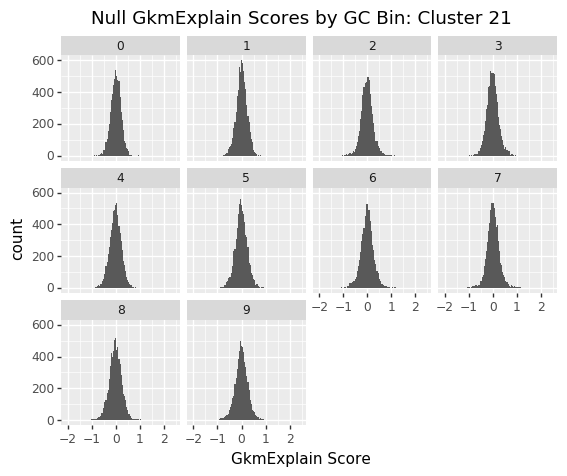

<ggplot: (-9223363266037437352)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.004198590523314672
Stdev: 	 0.21429160008518694

KstestResult(statistic=0.0018884660445867008, pvalue=0.9743900585384915)



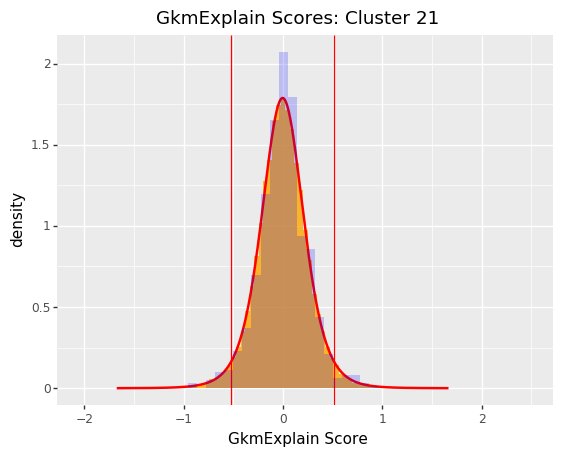

<ggplot: (8770758390718)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

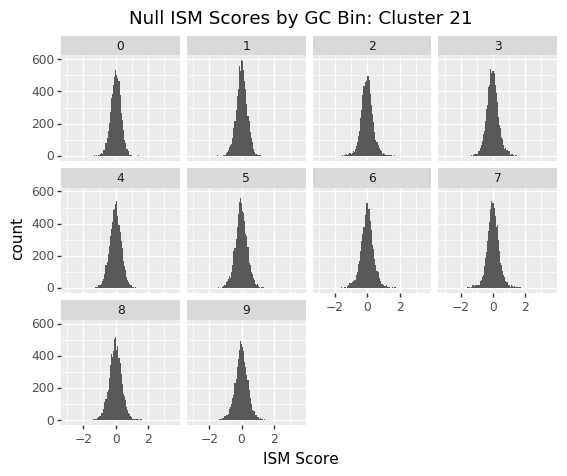

<ggplot: (-9223363266096389260)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.006220206438687158
Stdev: 	 0.31914580236350054

KstestResult(statistic=0.001731522359842308, pvalue=0.9897957865744098)



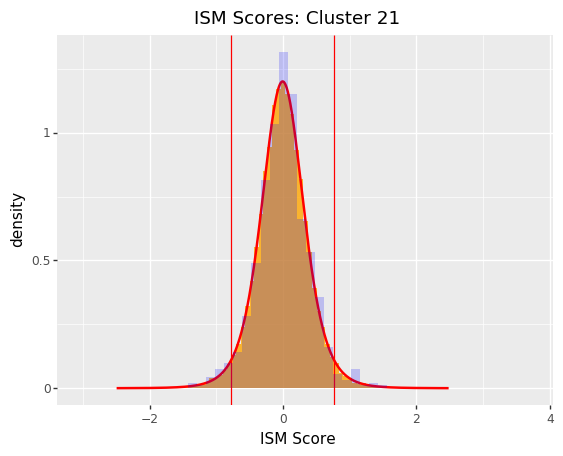

<ggplot: (-9223363266096742368)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

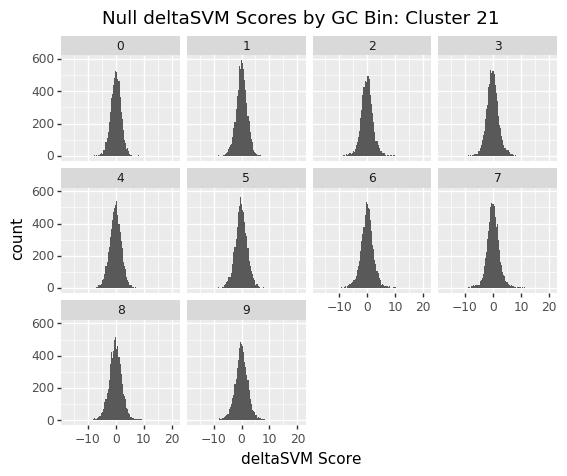

<ggplot: (-9223363266096748705)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.035569272551064776
Stdev: 	 1.845465585255145

KstestResult(statistic=0.0017082812178549345, pvalue=0.9913014613742905)



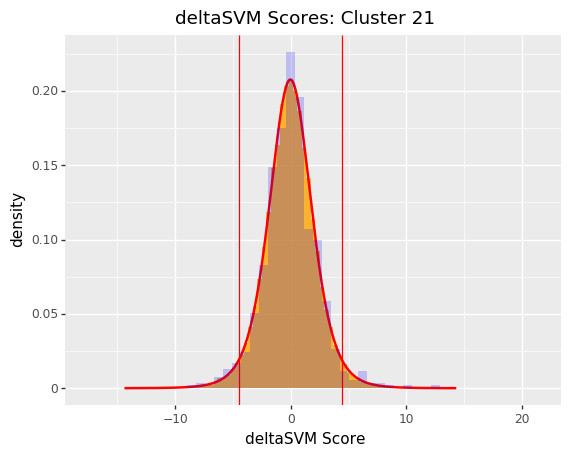

<ggplot: (-9223363266097095231)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

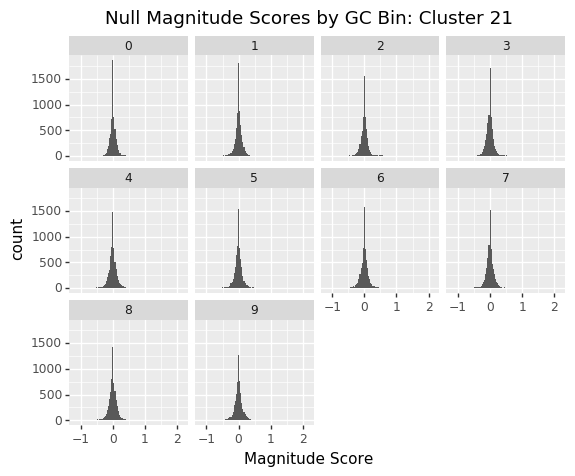

<ggplot: (8770757734450)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.0016156924693553178
Stdev: 	 0.0673228832796822

KstestResult(statistic=0.03611349769680028, pvalue=3.595179974457978e-74)



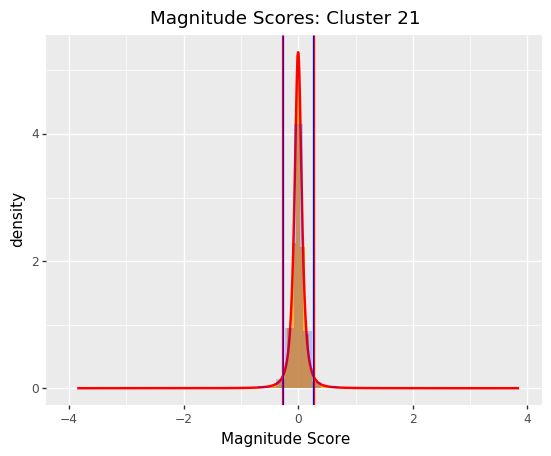

<ggplot: (8770757322623)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

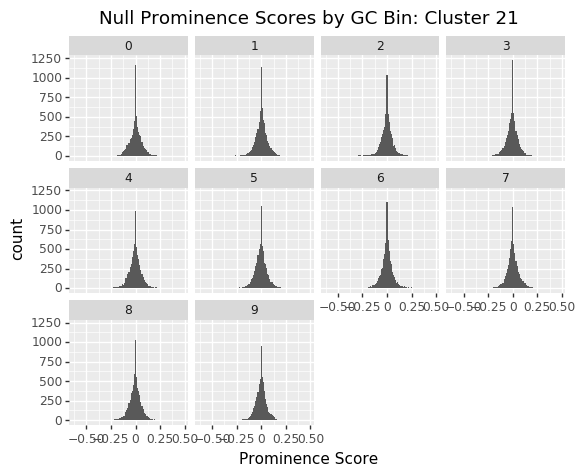

<ggplot: (-9223363266096748621)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0011021476350861392
Stdev: 	 0.041099759705732666

KstestResult(statistic=0.03481343622883437, pvalue=5.884542872954673e-69)



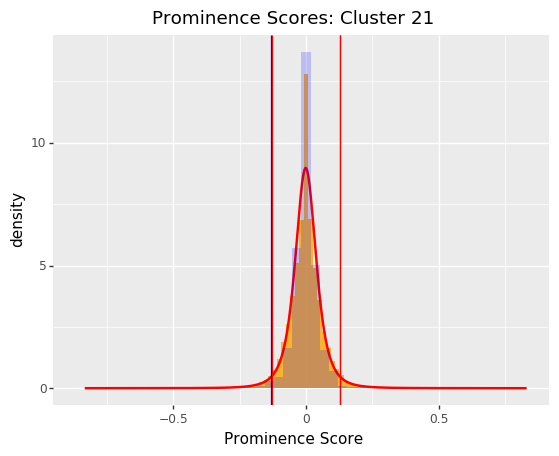

<ggplot: (8770756911834)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.004082449629444528
Stdev: 	 0.010769927503978132



KstestResult(statistic=0.01746961965770616, pvalue=1.653633278654188e-265)



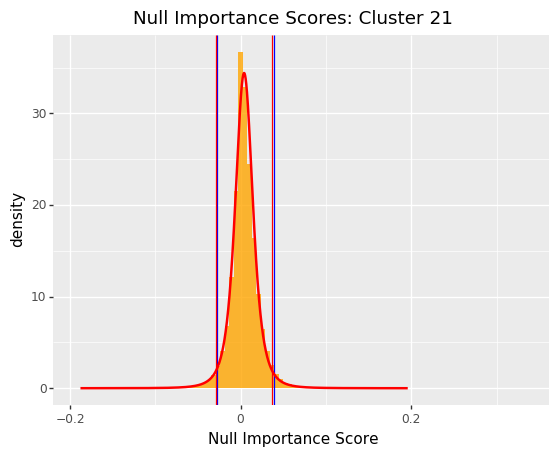

<ggplot: (-9223363266097860341)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-Values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
snp_scores.sort_values(by=['confidence'], ascending=False, inplace=True)
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/Cluster'
                       + cluster + '.' + celltype + '.updated.snp_scores.tsv', sep='\t', index=False)

sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NA']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NA']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)

print('Unique Significant SNPs:')
print()
display(unique_sig_snps)
print()
print('Shape: ', unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Scored: ', '\t', '\t', '\t', '\t', len(snp_scores))
print('Unique SNPs Scored: ', '\t', '\t', '\t', '\t', len(snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_seqlet,inactive_seqlet,diff_seqlet,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
204,chr17,45852666,45852667,rs62054825,G,A,G,A,G,A,+,54,0.482,0.726648,1.137659,6.477922,0.606930,0.264305,3,23andme_PD_hg38,1.25e-22,True,CCGGAAGTGGA,CCAGAAGTGGA,CC(G/A)GAAGTGGA,effect,0.013608,0.010963,0.011667,0.005253,0.002488,2
471,chr2,95074354,95074355,rs7585473,T,G,T,G,G,T,-,85,0.571,0.952735,1.486779,8.517345,0.479429,0.197756,6,Nalls_23andMe,0.0367323,False,CATTGTC,CATGGTC,CAT(T/G)GTC,effect,0.003934,0.003125,0.003247,0.011705,0.010538,2
196,chr17,45848599,45848600,rs62054817,G,A,G,A,G,A,+,54,0.566,-0.892088,-1.405706,-8.075495,-0.890209,-0.192899,6,23andme_PD_hg38,1.14e-22,True,CCAGTAGAGGGC,CCGGTAGAGGGC,CC(A/G)GTAGAGGGC,noneffect,0.005645,0.004298,0.004403,0.000891,0.012873,2
503,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.434,-0.558458,-0.870688,-4.888229,-0.546741,-0.181787,2,Alzheimers_Jansen_2018,9.13e-17,False,GCCCCGCCCA,GCCCTGCCCA,GCCC(C/T)GCCCA,noneffect,0.040217,0.034051,0.037806,0.009401,0.016498,2
360,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.693,0.825898,1.311138,7.577617,0.696939,0.172169,9,23andme_PD_hg38,9.49e-14,True,GCGCCACCTACAG,GAGCCACCTACAG,G(C/A)GCCACCTACAG,effect,0.007729,0.005745,0.005722,0.003410,0.018833,2
128,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.622,-0.869904,-1.361795,-8.021217,-0.830820,-0.166283,8,Alzheimers_Lambert_2013,4.79e-05,True,TTGGCCCCGCCCC,TTGGCCTCGCCCC,TTGGCC(C/T)CGCCCC,noneffect,0.006361,0.005013,0.004550,0.001413,0.023041,2
234,chr17,45897109,45897110,rs80346216,T,G,G,T,G,T,-,54,0.609,0.669061,1.045238,5.971154,0.577854,0.146981,8,23andme_PD_hg38,3.94e-22,True,GCCGCTAGGGG,GCCGCGAGGGG,GCCGC(T/G)AGGGG,effect,0.019177,0.015755,0.016500,0.006114,0.031705,2
643,chr6,27772520,27772521,rs760587,C,A,C,A,C,A,-,110,0.498,-0.617307,-0.969784,-5.531285,-0.596514,-0.147984,3,Nalls_23andMe,6.44e-06,False,CAGCAAACAAAGGC,CAGCAACCAAAGGC,CAGCAA(A/C)CAAAGGC,noneffect,0.027746,0.022501,0.023666,0.007158,0.034101,2
173,chr17,45783750,45783751,rs62057073,T,C,C,T,C,T,-,54,0.691,-0.526785,-0.809214,-4.947121,-0.451207,-0.141306,9,23andme_PD_hg38,2.16e-22,True,GCTCCTCCTAG,GCTCCTCTTAG,GCTCCTC(C/T)TAG,noneffect,0.049278,0.044287,0.036197,0.016375,0.039693,2
405,chr19,18462023,18462024,rs8103622,T,C,C,T,C,T,+,69,0.581,-0.593200,-0.974957,-5.556335,-0.590954,-0.067686,7,Alzheimers_Kunkle_2019,1.28e-05,True,AGAGCGCCACCTGCTG,AGAGTGCCACCTGCTG,AGAG(C/T)GCCACCTGCTG,noneffect,0.032268,0.022027,0.023245,0.007281,0.223318,1



Shape:  (32, 32)

SNPs with Significant Scores: 	 	 	 32
Significant SNPs with Low Confidence: 	 	 19
Significant SNPs with Moderate Confidence: 	 4
Significant SNPs with High Confidence: 	 	 9

Total SNPs Scored:  	 	 	 	 681
Unique SNPs Scored:  	 	 	 	 605


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 204

RSID: rs62054825 	 	 || 	 chr17 : 45852666 - 45852667 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 1.2500E-22 	 || 	 Coloc: True

Prominence P-Value: 2.4885E-03 	 || 	 Magnitude P-Value: 5.2535E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 1.3608E-02 	 || 	 ISM P-Value: 1.0963E-02 	 || 	 deltaSVM P-Value: 1.1667E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Seqlet: CCGGAAGTGGA



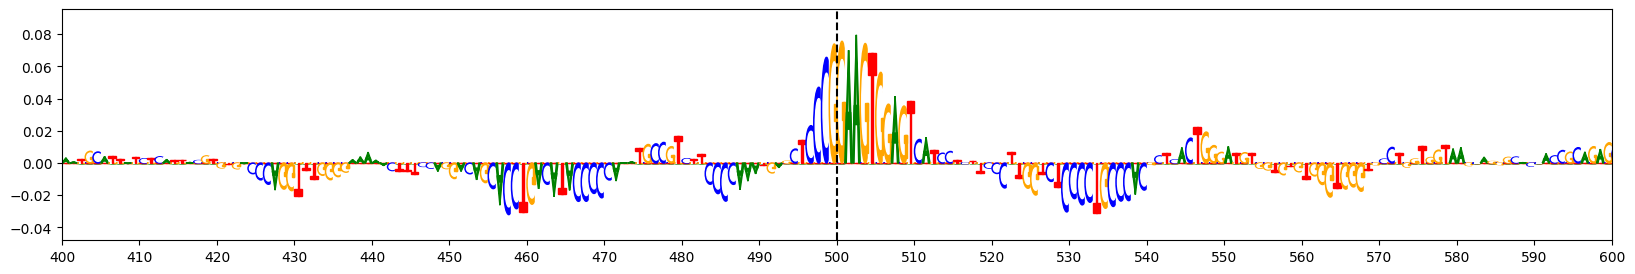


Non-Effect Allele: A 	 	 || 	 Inactive Seqlet: CCAGAAGTGGA



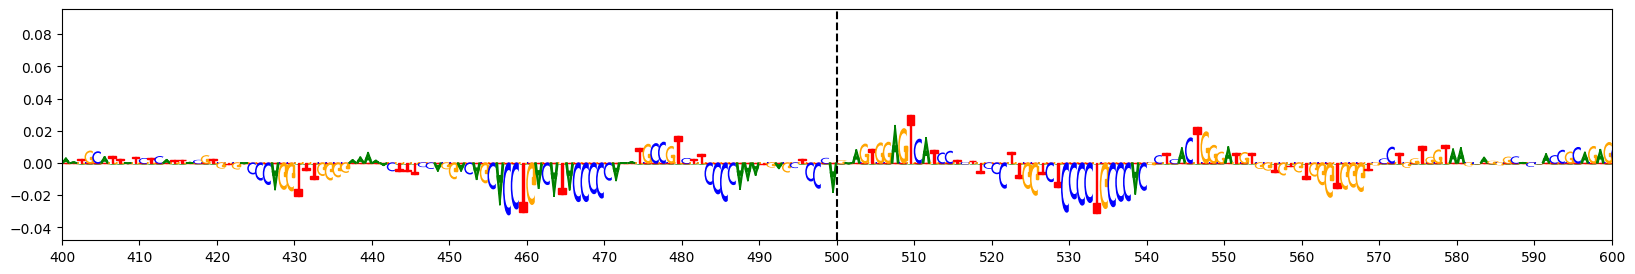


Difference Seqlet: CC(G/A)GAAGTGGA



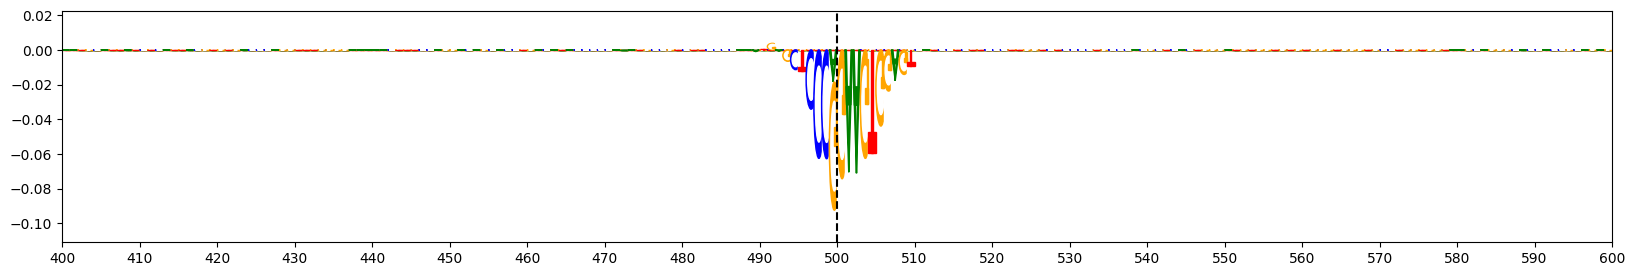


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 471

RSID: rs7585473 	 	 || 	 chr2 : 95074354 - 95074355 	 || 	 Locus: 85

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 3.6732E-02 	 || 	 Coloc: False

Prominence P-Value: 1.0538E-02 	 || 	 Magnitude P-Value: 1.1705E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 3.9342E-03 	 || 	 ISM P-Value: 3.1251E-03 	 || 	 deltaSVM P-Value: 3.2472E-03

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Seqlet: CATTGTC



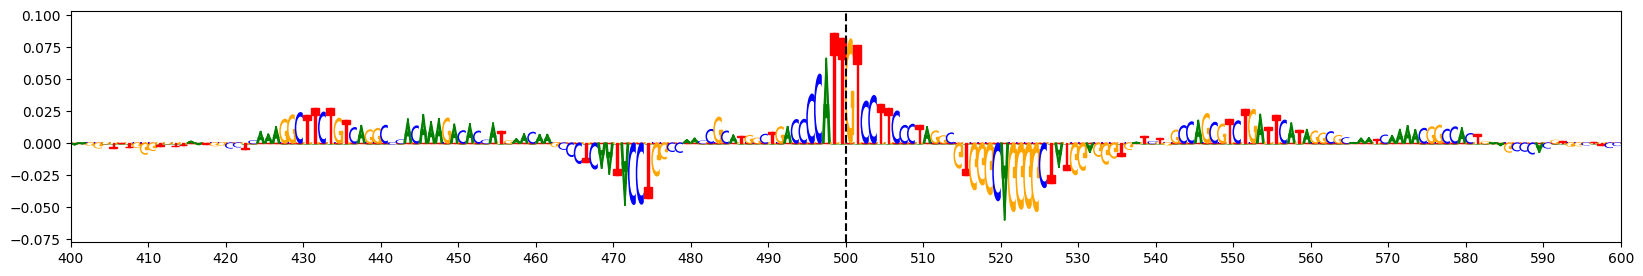


Non-Effect Allele: G 	 	 || 	 Inactive Seqlet: CATGGTC



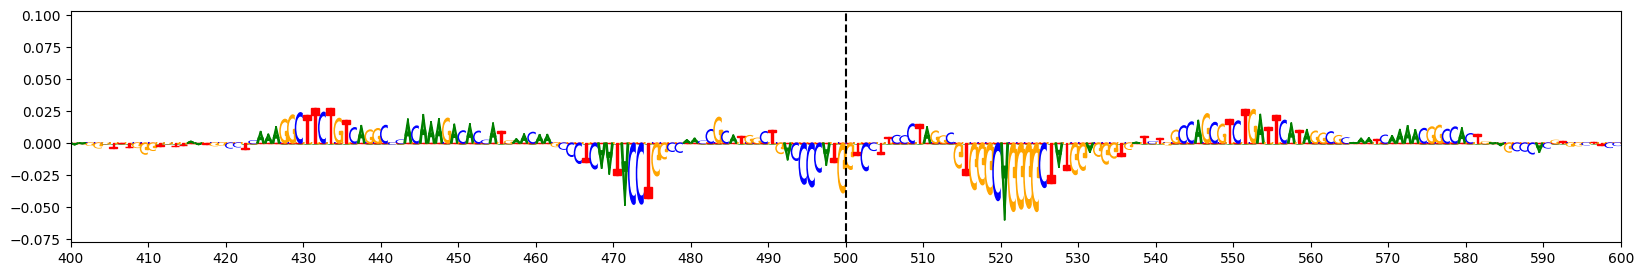


Difference Seqlet: CAT(T/G)GTC



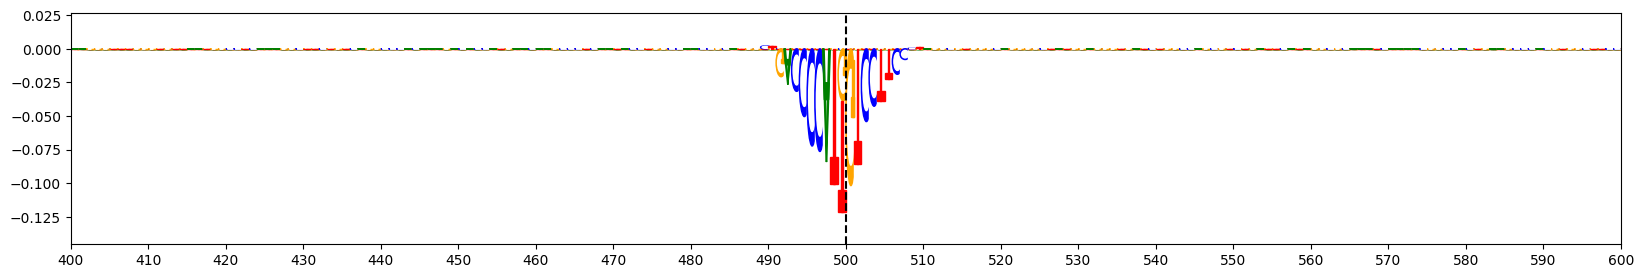


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 196

RSID: rs62054817 	 	 || 	 chr17 : 45848599 - 45848600 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 1.1400E-22 	 || 	 Coloc: True

Prominence P-Value: 1.2873E-02 	 || 	 Magnitude P-Value: 8.9094E-04 	 || 	 Confidence: 2

GkmExplain P-Value: 5.6452E-03 	 || 	 ISM P-Value: 4.2979E-03 	 || 	 deltaSVM P-Value: 4.4032E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: A 	 	 || 	 Active Seqlet: CCAGTAGAGGGC



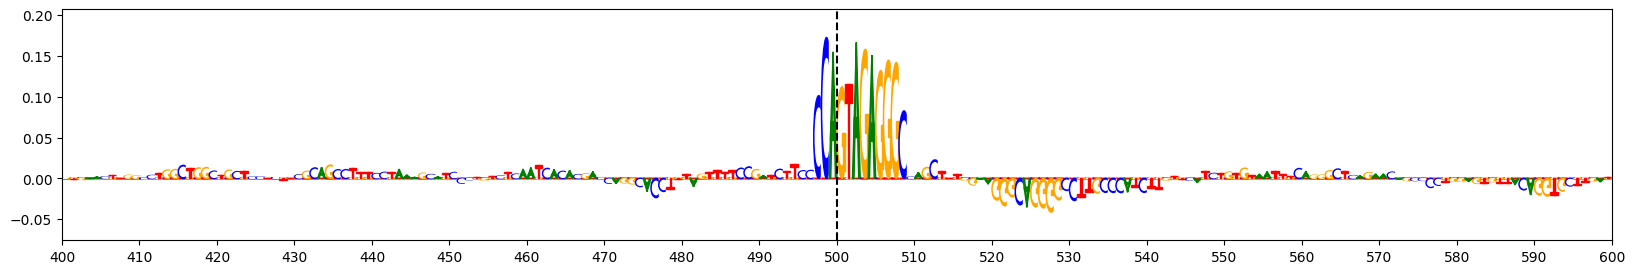


Effect Allele: G 	 	 || 	 Inactive Seqlet: CCGGTAGAGGGC



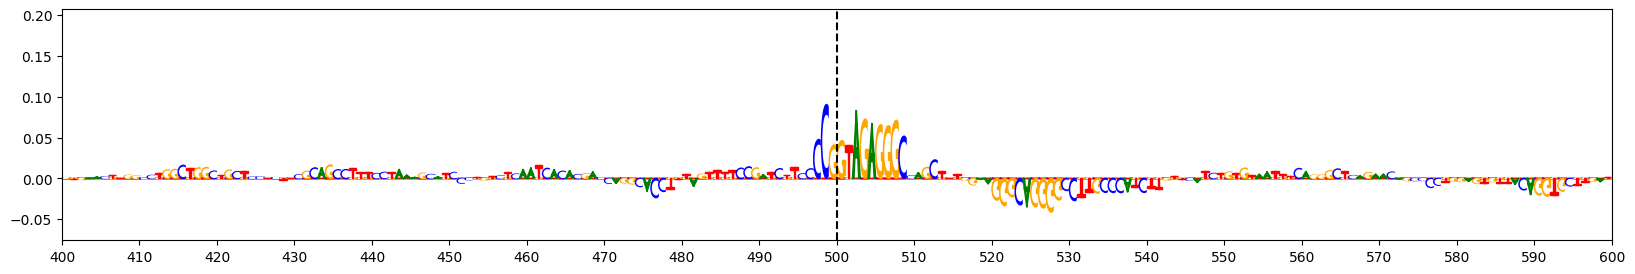


Difference Seqlet: CC(A/G)GTAGAGGGC



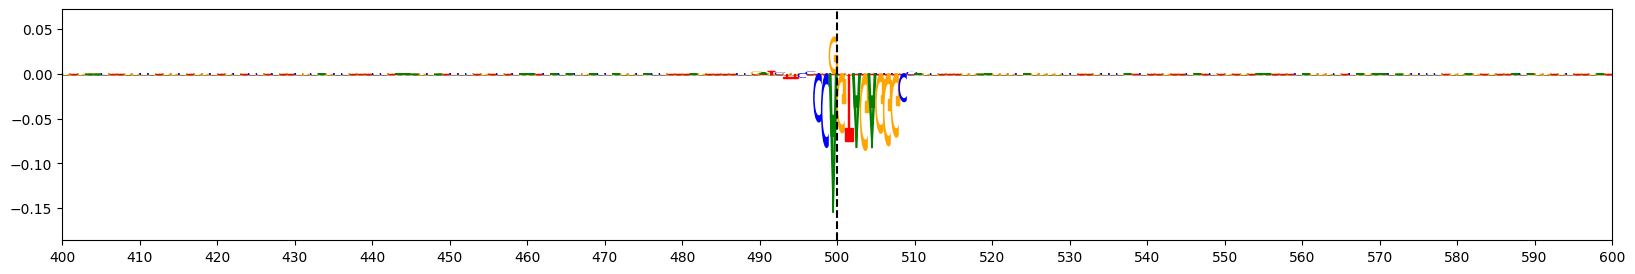


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 503

RSID: rs13025717 	 	 || 	 chr2 : 127128581 - 127128582 	 || 	 Locus: 77

GWAS: Alzheimers_Jansen_2018 	 || 	 GWAS P-Value: 9.1300E-17 	 || 	 Coloc: False

Prominence P-Value: 1.6498E-02 	 || 	 Magnitude P-Value: 9.4009E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 4.0217E-02 	 || 	 ISM P-Value: 3.4051E-02 	 || 	 deltaSVM P-Value: 3.7806E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: GCCCCGCCCA



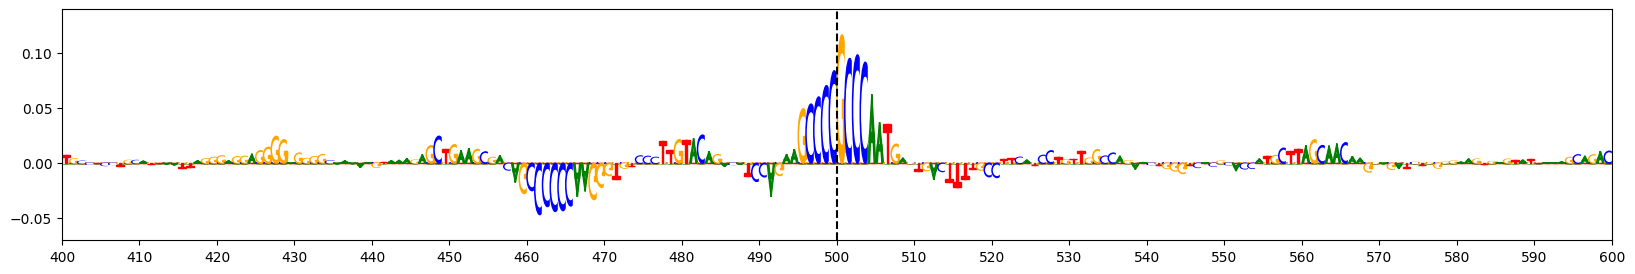


Effect Allele: T 	 	 || 	 Inactive Seqlet: GCCCTGCCCA



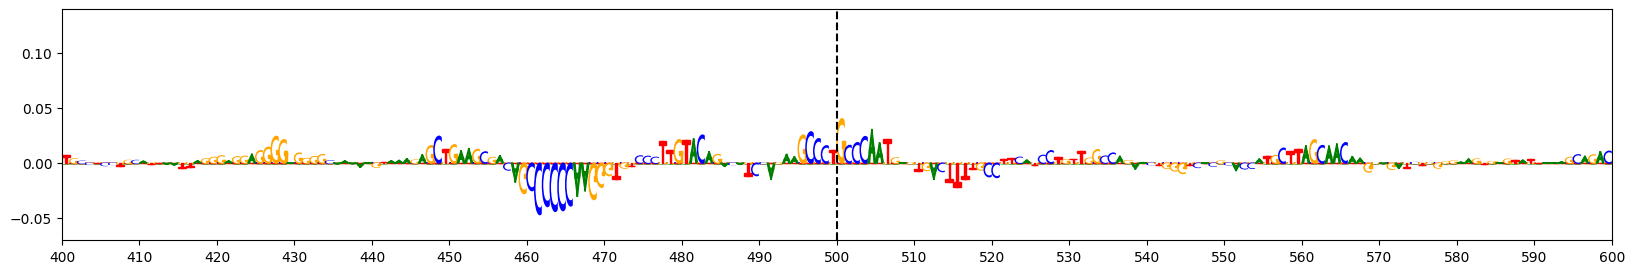


Difference Seqlet: GCCC(C/T)GCCCA



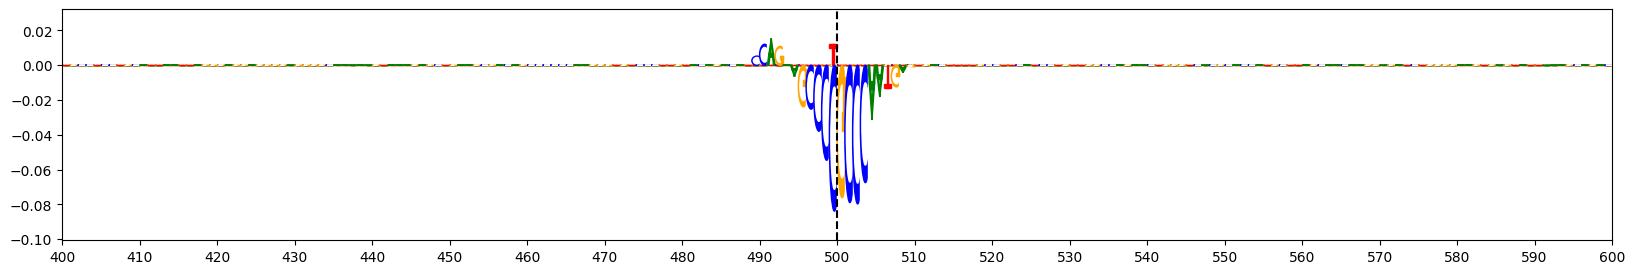


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 360

RSID: rs199523 	 	 || 	 chr17 : 46771150 - 46771151 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 9.4900E-14 	 || 	 Coloc: True

Prominence P-Value: 1.8833E-02 	 || 	 Magnitude P-Value: 3.4101E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 7.7295E-03 	 || 	 ISM P-Value: 5.7453E-03 	 || 	 deltaSVM P-Value: 5.7219E-03

----------------------------------------------------------------------------------------------------

Effect Allele: C 	 	 || 	 Active Seqlet: GCGCCACCTACAG



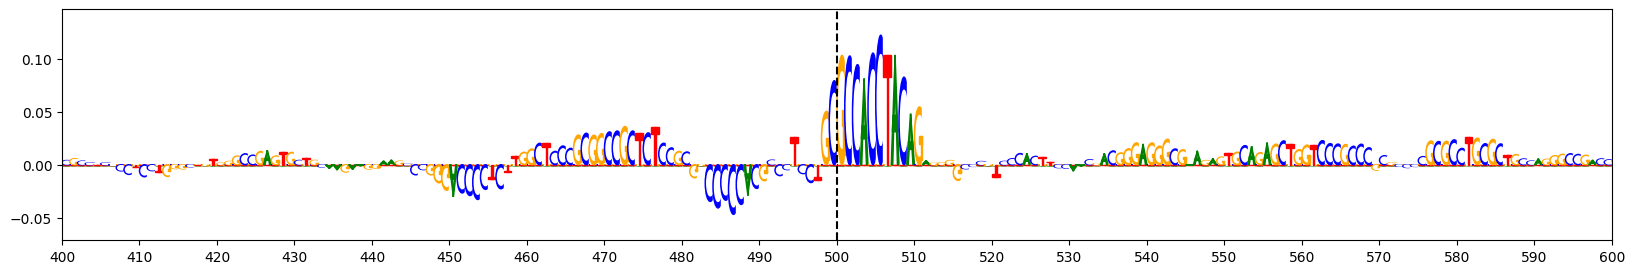


Non-Effect Allele: A 	 	 || 	 Inactive Seqlet: GAGCCACCTACAG



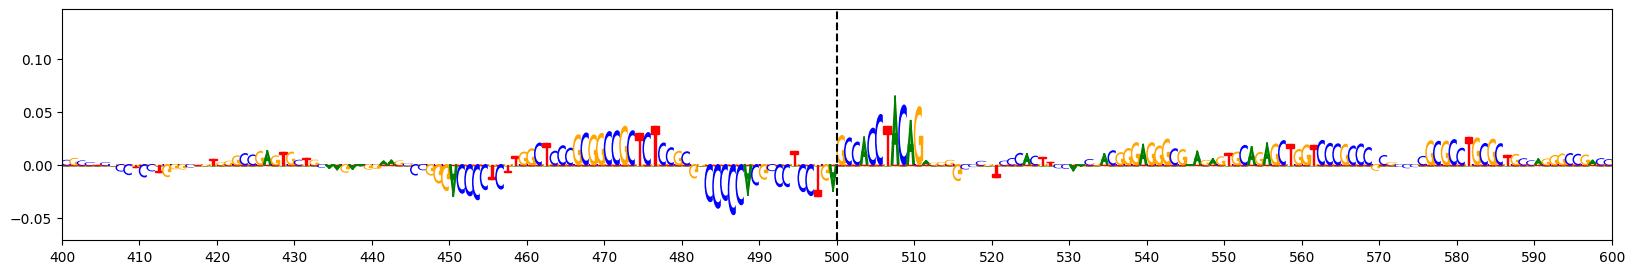


Difference Seqlet: G(C/A)GCCACCTACAG



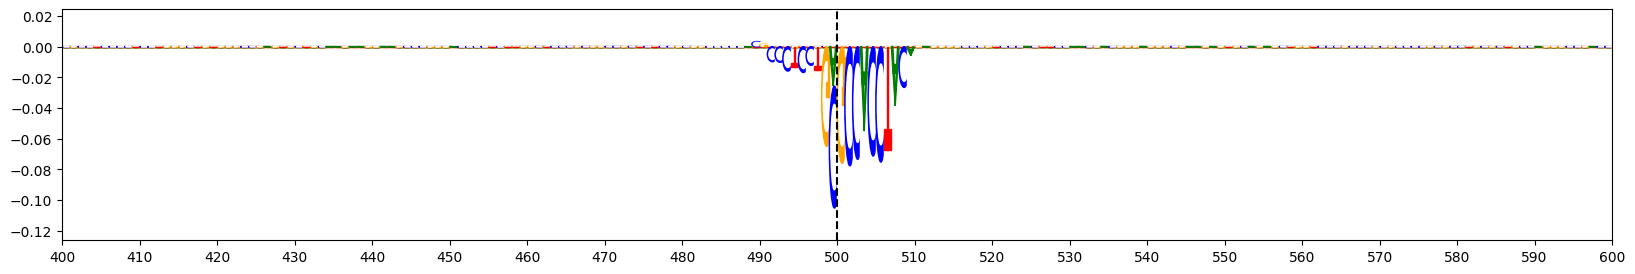


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 128

RSID: rs79436576 	 	 || 	 chr17 : 4901871 - 4901872 	 || 	 Locus: 55

GWAS: Alzheimers_Lambert_2013 	 || 	 GWAS P-Value: 4.7900E-05 	 || 	 Coloc: True

Prominence P-Value: 2.3041E-02 	 || 	 Magnitude P-Value: 1.4132E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 6.3606E-03 	 || 	 ISM P-Value: 5.0133E-03 	 || 	 deltaSVM P-Value: 4.5503E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: TTGGCCCCGCCCC



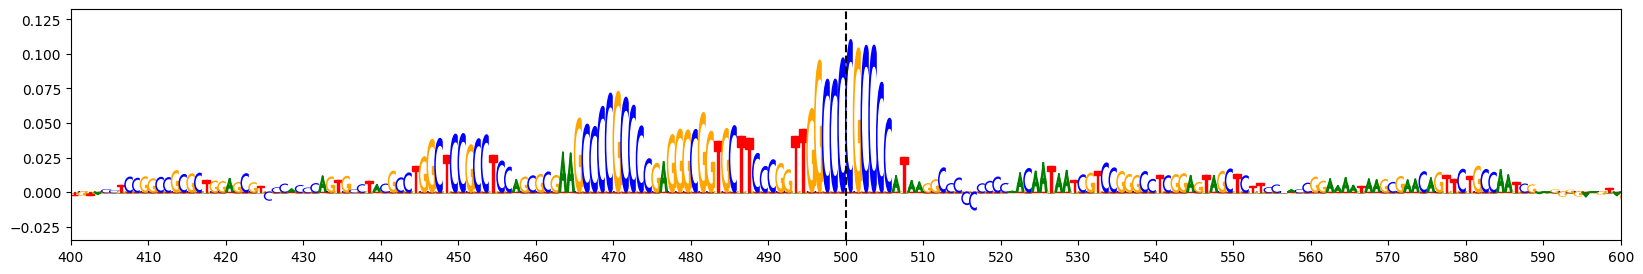


Effect Allele: T 	 	 || 	 Inactive Seqlet: TTGGCCTCGCCCC



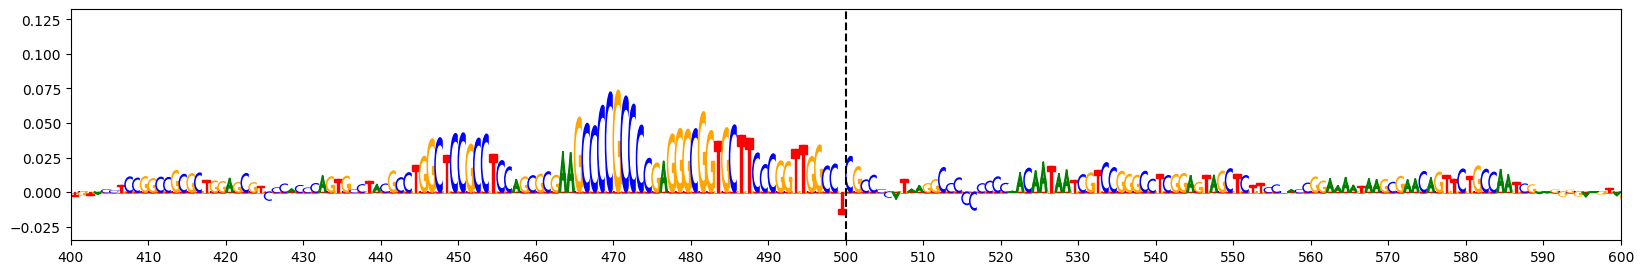


Difference Seqlet: TTGGCC(C/T)CGCCCC



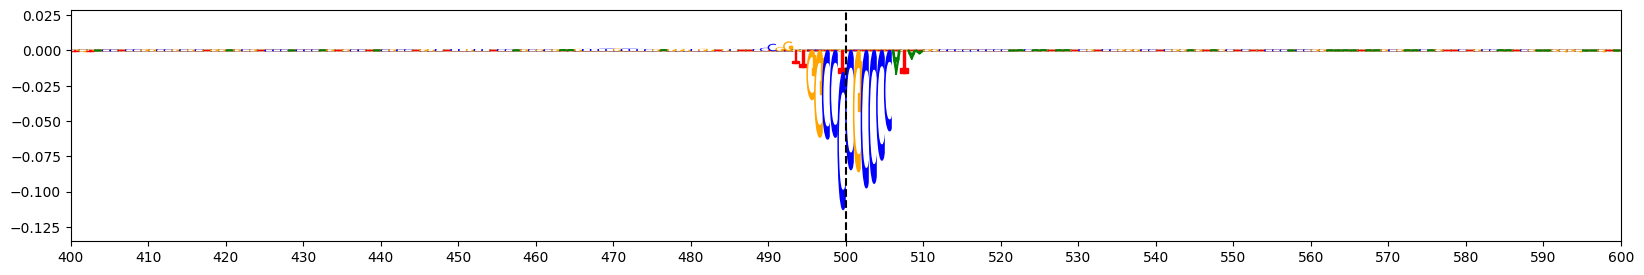


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 234

RSID: rs80346216 	 	 || 	 chr17 : 45897109 - 45897110 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 3.9400E-22 	 || 	 Coloc: True

Prominence P-Value: 3.1705E-02 	 || 	 Magnitude P-Value: 6.1137E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 1.9177E-02 	 || 	 ISM P-Value: 1.5755E-02 	 || 	 deltaSVM P-Value: 1.6500E-02

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Seqlet: GCCGCTAGGGG



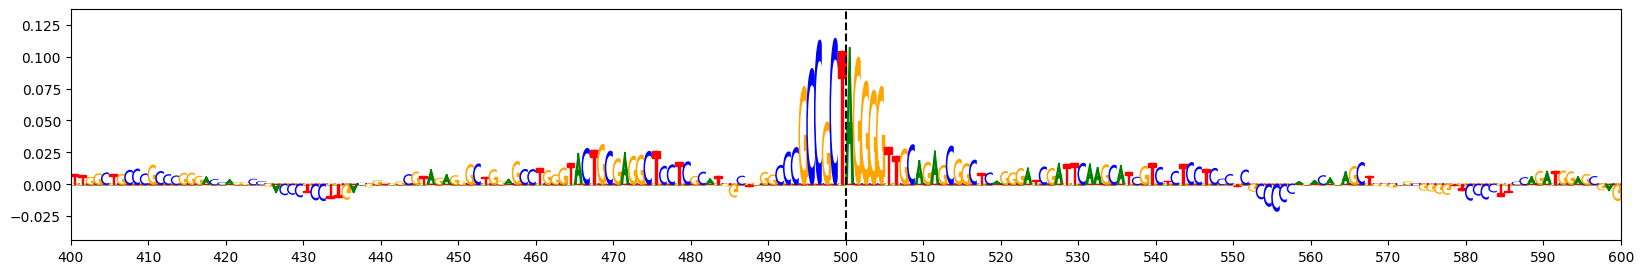


Non-Effect Allele: G 	 	 || 	 Inactive Seqlet: GCCGCGAGGGG



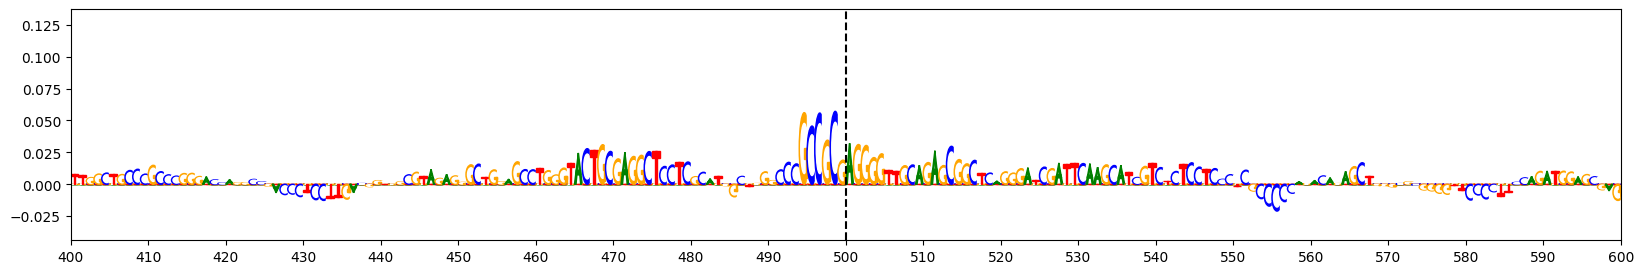


Difference Seqlet: GCCGC(T/G)AGGGG



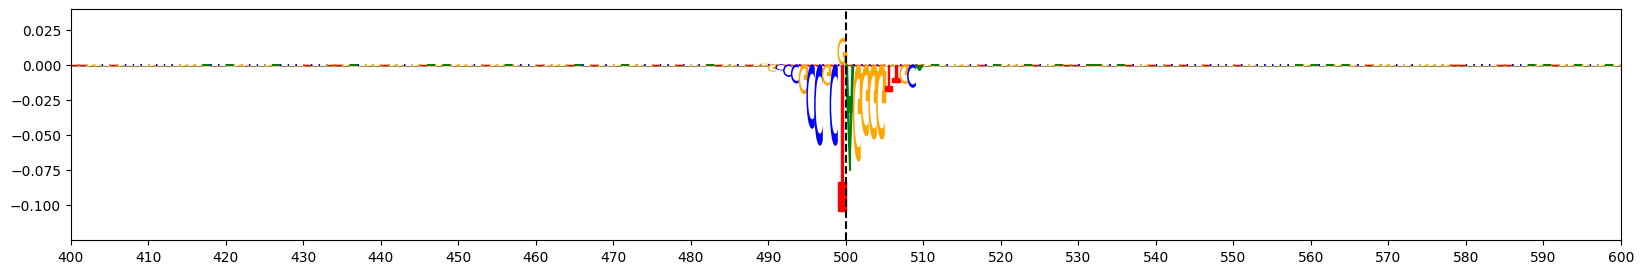


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 643

RSID: rs760587 	 	 || 	 chr6 : 27772520 - 27772521 	 || 	 Locus: 110

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 6.4400E-06 	 || 	 Coloc: False

Prominence P-Value: 3.4101E-02 	 || 	 Magnitude P-Value: 7.1582E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 2.7746E-02 	 || 	 ISM P-Value: 2.2501E-02 	 || 	 deltaSVM P-Value: 2.3666E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: A 	 	 || 	 Active Seqlet: CAGCAAACAAAGGC



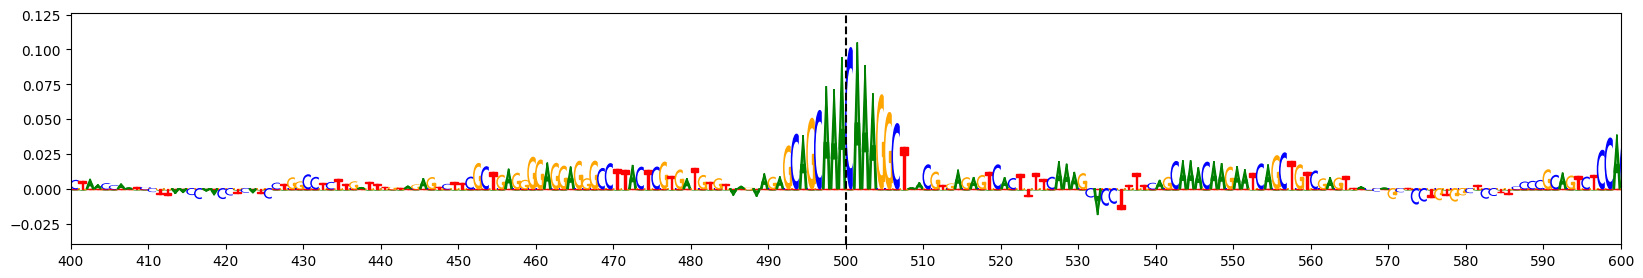


Effect Allele: C 	 	 || 	 Inactive Seqlet: CAGCAACCAAAGGC



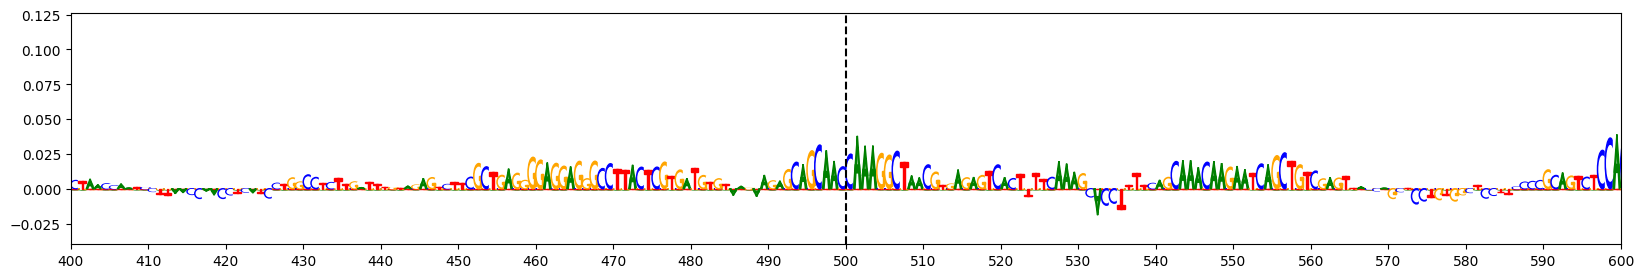


Difference Seqlet: CAGCAA(A/C)CAAAGGC



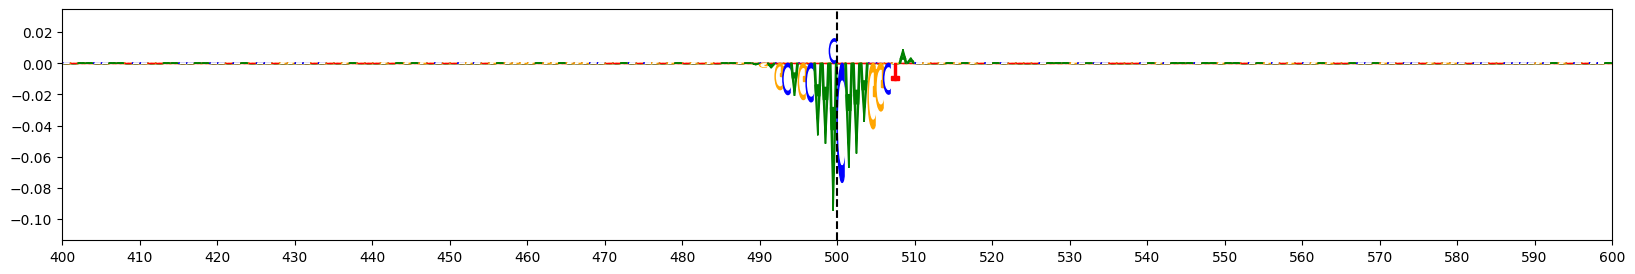


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 173

RSID: rs62057073 	 	 || 	 chr17 : 45783750 - 45783751 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 2.1600E-22 	 || 	 Coloc: True

Prominence P-Value: 3.9693E-02 	 || 	 Magnitude P-Value: 1.6375E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 4.9278E-02 	 || 	 ISM P-Value: 4.4287E-02 	 || 	 deltaSVM P-Value: 3.6197E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: GCTCCTCCTAG



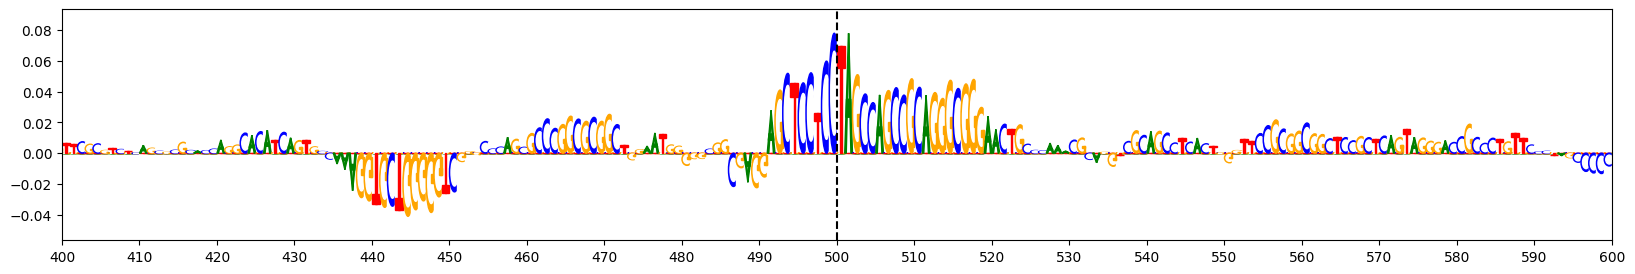


Effect Allele: T 	 	 || 	 Inactive Seqlet: GCTCCTCTTAG



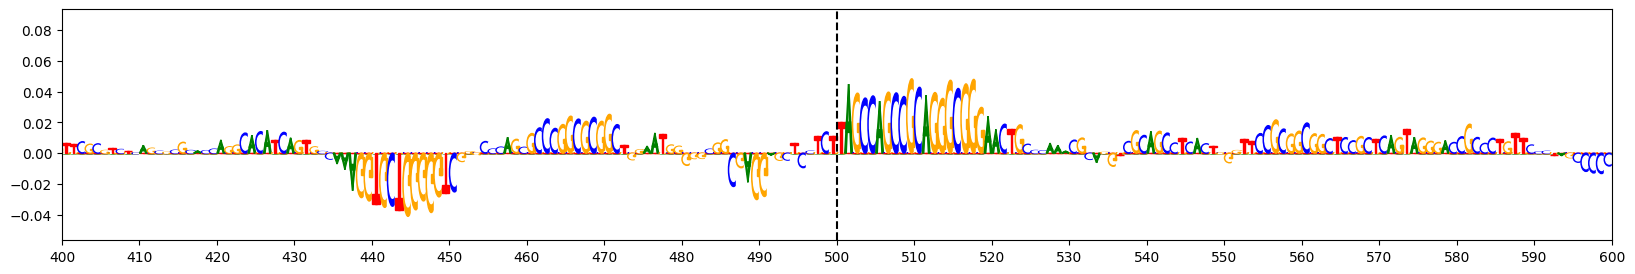


Difference Seqlet: GCTCCTC(C/T)TAG



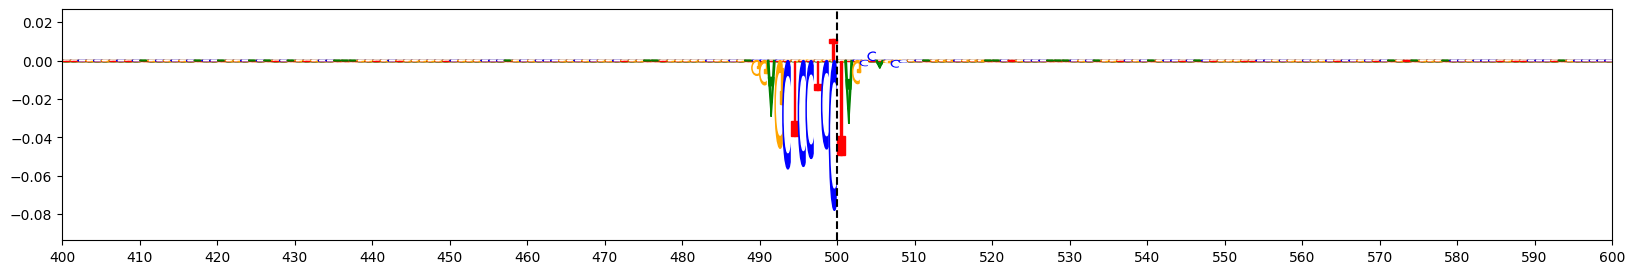


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in unique_sig_snps.loc[unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'GWAS P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Seqlet:', row['diff_seqlet'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_observed_noneffect_scores[index] - merged_observed_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_observed_effect_scores[index] - merged_observed_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
unique_sig_snps['fc_track'] = fc_tracks
unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15597081184387207
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1637744903564453
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15972542762756348
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15912914276123047
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16150712966918945
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.25052857398986816
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16576194763183594
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1618034839630127
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15940546989440918
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16562938690185547
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16294431686401367
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1614987850189209
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15923094749450684
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17222905158996582
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.24979162216186523
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1622002124786377
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16465353965759277
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17422199249267578
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17267537117004395
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16219282150268555
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16665124893188477
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.159165620803833
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17380285263061523
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.2552804946899414
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16487836837768555
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1681375503540039
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16627955436706543
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1623396873474121
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17097139358520508
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18212604522705078
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1631176471710205
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17287039756774902
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.2584354877471924
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17837023735046387
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17781853675842285
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18203186988830566
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20456314086914062
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18248820304870605
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17415070533752441
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20466065406799316
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.19210171699523926
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.27570199966430664
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17227983474731445
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18361997604370117
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17557001113891602
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.22408699989318848
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1982715129852295
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17998504638671875
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1742386817932129
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.2065730094909668
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.27481579780578613
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17485570907592773
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18194580078125
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1828930377960205
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0


INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17520952224731445
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16977953910827637
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20934534072875977
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.19013619422912598
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18012475967407227
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1939.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.49771595001220703
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1939.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1811201572418213
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18336963653564453
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17468643188476562
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17730998992919922
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_seqlet', 'diff_seqlet', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)
print()
print('Shape: ', final_sig_snps.shape)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_seqlet,diff_seqlet,active_allele,fc_track,pval_track
204,chr17,45852666,45852667,rs62054825,G,A,G,A,+,54,23andme_PD_hg38,1.25e-22,True,0.013608,0.010963,0.011667,0.005253,0.002488,2,CCGGAAGTGGA,CC(G/A)GAAGTGGA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
471,chr2,95074354,95074355,rs7585473,T,G,G,T,-,85,Nalls_23andMe,0.0367323,False,0.003934,0.003125,0.003247,0.011705,0.010538,2,CATTGTC,CAT(T/G)GTC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
196,chr17,45848599,45848600,rs62054817,G,A,G,A,+,54,23andme_PD_hg38,1.14e-22,True,0.005645,0.004298,0.004403,0.000891,0.012873,2,CCAGTAGAGGGC,CC(A/G)GTAGAGGGC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
503,chr2,127128581,127128582,rs13025717,T,C,C,T,+,77,Alzheimers_Jansen_2018,9.13e-17,False,0.040217,0.034051,0.037806,0.009401,0.016498,2,GCCCCGCCCA,GCCC(C/T)GCCCA,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
360,chr17,46771150,46771151,rs199523,C,A,A,C,-,54,23andme_PD_hg38,9.49e-14,True,0.007729,0.005745,0.005722,0.003410,0.018833,2,GCGCCACCTACAG,G(C/A)GCCACCTACAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
128,chr17,4901871,4901872,rs79436576,T,C,C,T,+,55,Alzheimers_Lambert_2013,4.79e-05,True,0.006361,0.005013,0.004550,0.001413,0.023041,2,TTGGCCCCGCCCC,TTGGCC(C/T)CGCCCC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
234,chr17,45897109,45897110,rs80346216,T,G,G,T,-,54,23andme_PD_hg38,3.94e-22,True,0.019177,0.015755,0.016500,0.006114,0.031705,2,GCCGCTAGGGG,GCCGC(T/G)AGGGG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
643,chr6,27772520,27772521,rs760587,C,A,C,A,-,110,Nalls_23andMe,6.44e-06,False,0.027746,0.022501,0.023666,0.007158,0.034101,2,CAGCAAACAAAGGC,CAGCAA(A/C)CAAAGGC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
173,chr17,45783750,45783751,rs62057073,T,C,C,T,-,54,23andme_PD_hg38,2.16e-22,True,0.049278,0.044287,0.036197,0.016375,0.039693,2,GCTCCTCCTAG,GCTCCTC(C/T)TAG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
405,chr19,18462023,18462024,rs8103622,T,C,C,T,+,69,Alzheimers_Kunkle_2019,1.28e-05,True,0.032268,0.022027,0.023245,0.007281,0.223318,1,AGAGCGCCACCTGCTG,AGAG(C/T)GCCACCTGCTG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...



Shape:  (32, 24)
